<center>
<div style="background-color: #8B0000; padding: 10px;">

# Twitter Sentiment Analysis
</div>



This project aims to classify tweets into one of three categories: Positive, Negative, or Neutral. To achieve this, I plan to use a recurrent neural network (RNN) architecture in combination with natural language processing tools from the Natural Language Toolkit (NLTK) and TensorFlow.
![alt text](1538479344425.jpg)

table of content

1. [Import libs](#import-libs)
2. [Data](#load-data)
3. [Data Visualization](#visualization)

   3.1 [Distribuiton](#distribution)

   3.2 [Pie Chart](#pie-chart)

   3.3 [WordCloud](#wordcloud)
4. [Data Preprocessing](#clean-text)

   4.1 [Part of Speech (POS)](#part-of-speech-pos)

   4.2 [Named Entity Recognition (NER)](#named-entity-recognition-ner)

   4.3 [Chunking](#chunking)

   4.4 [Tokenizer](#tokenizer)

   4.5 [CountVectorizer](#countvectorizer)

   4.6 [TF_IDF](#tf_idf)

   4.7 [N_Grams](#n-grams)

   4.8 [Stemmer](#stemmer)

   4.9 [Drop the extra long sentences](#drop-the-extra-long-sentences)

   4.10 [SPlit Data ](#split-data)

   4.11 [Tokenizatioin & Pad Sequence](#tokenization--pad-sequence)

5. [Modeling](#modeling)

   5.1 [Model1 (Embedding only)](#model1-embadding-and-dense-layers)

   5.2 [Model2 CNN](#model2--cnn)

   5.3 [Model3 Bidirectional](#model3--bidirectional-lstm)





<center>
<div style="background-color: #DC143C; padding: 10px;">

### Import libs
</div>


In [47]:
import numpy as np
import pandas as pd 
import os 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import wordcloud
import re
import io
import zipfile
import random
import itertools
import spacy
import nltk 
from nltk.tokenize import RegexpTokenizer
import sklearn
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten,Bidirectional, Conv1D,MaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences

<center>
<div style="background-color: #DC143C; padding: 10px;">

### Load Data
</div>


In [2]:
archive_path='archive (1).zip'
with zipfile.ZipFile(archive_path,'r') as zip_ref:
    zip_ref.extractall('data.csv')

In [3]:
columns_name=["k","source","feeling","sentence"]
train_df=pd.read_csv('data/twitter_training.csv',names=columns_name)
train_df.drop(labels="k",axis=1,inplace=True)
print( f'this a csv file consist from {train_df.shape}\nincluding these data types\n{train_df.dtypes}')

this a csv file consist from (74682, 3)
including these data types
source      object
feeling     object
sentence    object
dtype: object


In [4]:
train_df.head()

,source,feeling,sentence
0,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,Borderlands,Positive,I am coming to the borders and I will kill you...
2,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,Borderlands,Positive,im coming on borderlands and i will murder you...
4,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [5]:
train_df.describe(include="all")

,source,feeling,sentence
count,74682,74682,73996
unique,32,4,69491
top,TomClancysRainbowSix,Negative,"At the same time, despite the fact that there ..."
freq,2400,22542,172


In [6]:
train_df.duplicated().sum()

3621

In [7]:

train_df.drop_duplicates(inplace=True)
train_df.dropna(inplace=True)
print(f"our dataframe now have the following shape{train_df.shape}")
train_df.reset_index(drop=True, inplace=True)

our dataframe now have the following shape(70958, 3)


In [8]:
# Cosidering Irrelevant to be Neutral 
train_df["feeling"]=train_df["feeling"].str.replace('Irrelevant','Neutral',regex=True)
land=train_df.source.value_counts()


<center>
<div style="background-color: #DC143C; padding: 10px;">

### visualization
</div>


<center>
<div style="background-color: #FFC0CB; padding: 10px;">
<span style="color: blue;">

#### Distribution


</span>


</div>

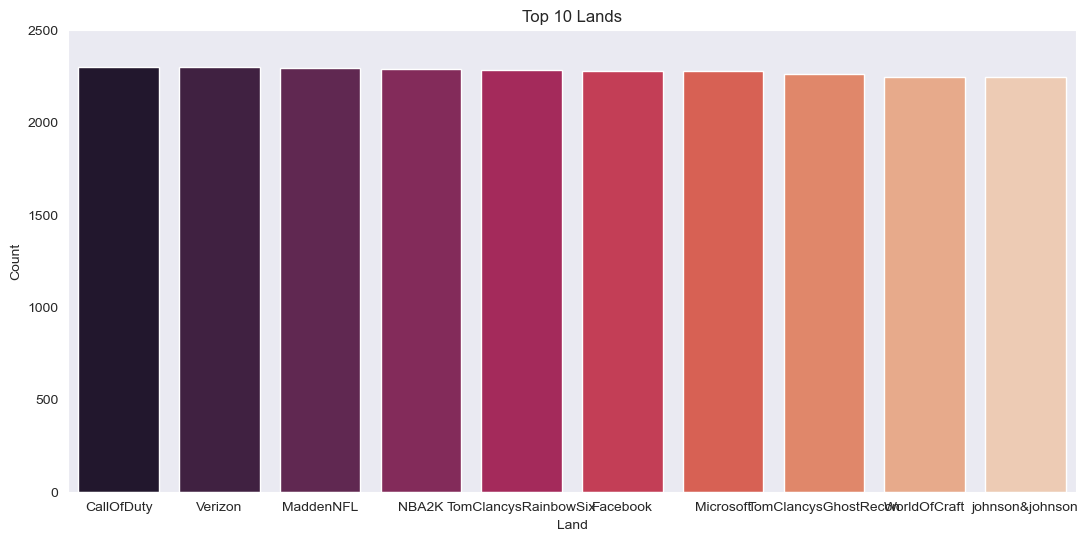

In [9]:
color_palette=['viridis', 'coolwarm', 'cubehelix', 'muted', 'deep', 'rocket', 'pastel',"rocket"]
set_style_options=['whitegrid','white','dark','ticks']
sns.set_style(random.choice(set_style_options))
plt.figure(figsize=(13,6))
bar=sns.barplot(x=land.index[:10],y=land.values[:10],palette=random.choice(color_palette))
plt.title('Top 10 Lands')
plt.xlabel('Land')
plt.ylabel('Count')
plt.ylim(0 , 2500)
plt.show()

<center>
<div style="background-color: #FFC0CB; padding: 10px;">
<span style="color: blue;">

#### Pie Chart


</span>


</div>

In [10]:
moods=train_df.feeling.value_counts()
moods.to_frame().T

feeling,Neutral,Negative,Positive
count,29844,21565,19549


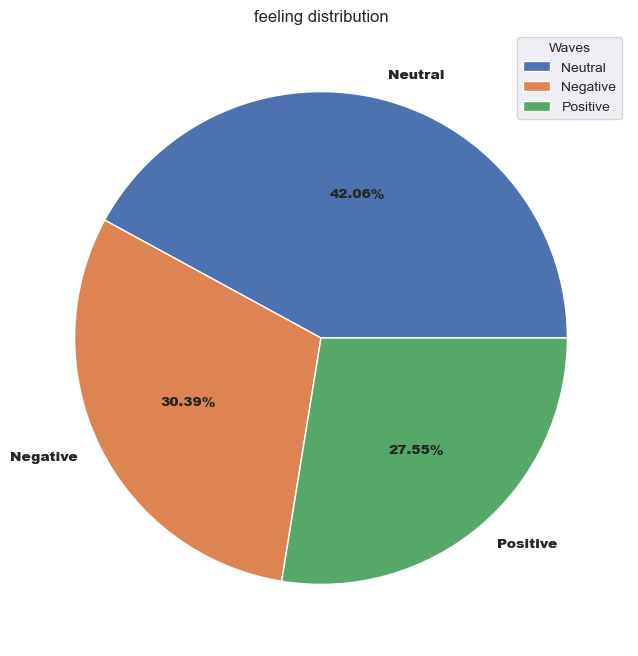

In [11]:
plt.figure(figsize=(8,8))
plt.pie(x=moods.values,labels=moods.keys(),autopct='%1.2f%%',
textprops={"fontsize":10,"fontweight":"black"}
,colors=sns.color_palette(random.choice(color_palette)))
plt.legend(loc='upper right', fontsize=10, title='Waves')
plt.title('feeling distribution')
plt.show()

In [12]:
map_colors=['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r']
pd.crosstab(train_df.source,train_df.feeling).style.background_gradient(subset=['Negative'],cmap=random.choice(map_colors))\
.background_gradient(subset=['Positive'],cmap=random.choice(map_colors))\
.background_gradient(subset=['Neutral'],cmap=random.choice(map_colors))

feeling,Negative,Neutral,Positive
source,,,
Amazon,564,1347,302
ApexLegends,568,1080,598
AssassinsCreed,364,409,1372
Battlefield,439,1241,556
Borderlands,415,816,961
CS-GO,334,1130,705
CallOfDuty,855,1024,425
CallOfDutyBlackopsColdWar,537,880,816
Cyberpunk2077,360,897,889


<center>
<div style="background-color: #FFC0CB; padding: 10px;">
<span style="color: blue;">

### WordCloud


</span>


</div>

In [13]:
background_colors = [
    'white',
    'black',
    'gray',  
    'red',
    'green',
    'blue',
    'yellow',
    'purple',
    'cyan',
    'magenta',
    'orange',
    'pink',
    'lightblue',
    'darkblue',
    'brown',
    'turquoise',
    'darkgray',  
    'lightgray', 
    'olive'
]

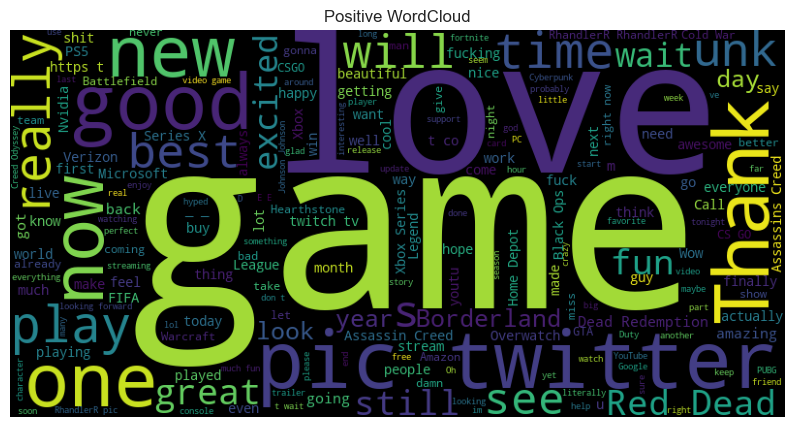

In [15]:
def make_word_cloud(text):
    wordcloud=WordCloud(width=800,height=400,background_color=random.choice(background_colors)).generate(text)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title('Positive WordCloud')
    plt.show()
all_words = ' '.join(train_df[train_df['feeling']=='Positive']['sentence'])
make_word_cloud(all_words)

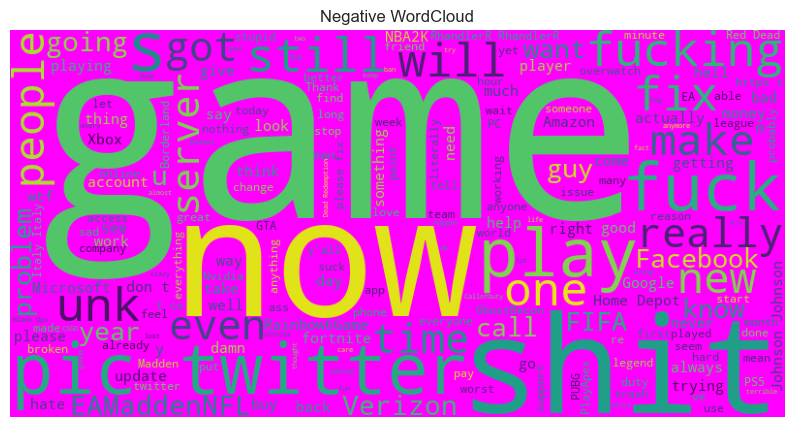

In [17]:
def make_word_cloud(text):
    wordcloud=WordCloud(width=800,height=400,background_color=random.choice(background_colors)).generate(text)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title('Negative WordCloud')
    plt.show()
all_words = ' '.join(train_df[train_df['feeling']=='Negative']['sentence'])
make_word_cloud(all_words)

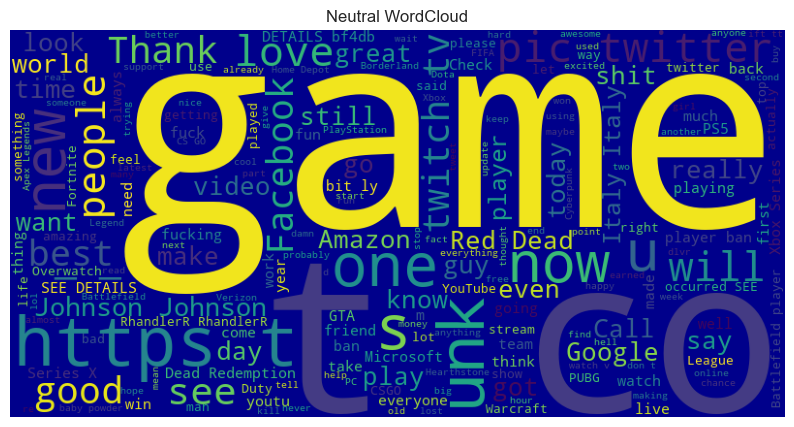

In [18]:
def make_word_cloud(text):
    wordcloud=WordCloud(width=800,height=400,background_color=random.choice(background_colors)).generate(text)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title('Neutral WordCloud')
    plt.show()
all_words = ' '.join(train_df[train_df['feeling']=='Neutral']['sentence'])
make_word_cloud(all_words)

<center>
<div style="background-color: #DC143C; padding: 10px;">

### Data Preprocessing
</div>



In [19]:
def emoji(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols
        u"\U0001F680-\U0001F6FF"  # transport and map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"  # dingbats
        u"\U000024C2-\U0001F251"  # various symbols
        "]+",
        flags=re.UNICODE
    )
    clean_text = emoji_pattern.findall( text)
    return clean_text
clean_emojis=[]
for i in range(0,len(train_df)):
    if i==20:
        pass
    else:
        clean_emojis.append(emoji(train_df.sentence[i]))
    single_list = list(itertools.chain.from_iterable(lst for lst in clean_emojis if lst))
print(single_list)



['🙂', '�', '�', '）', '🙂', '�', '■', '，', '。', '�', '：', '・', '�', '�', '：', '。', '�', '●', '🙂', '�', '★', '（', '。', '🙂', '�']


<center>
<div style="background-color: #FFC0CB; padding: 10px;">
<span style="color: blue;">

#### Clean Text


</span>


</div>

clean_text is designed to clean and preprocess text data by replacing certain contractions and abbreviations with their expanded forms. It takes a string text as input and performs the following replacements using regular expressions:

In [20]:
def clean_text(text):
    text = re.sub(r"won\'t", "would not", text)
    text = re.sub(r"im", "i am", text)
    text = re.sub(r"Im", "I am", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"don\'t", "do not", text)
    text = re.sub(r"shouldn\'t", "should not", text)
    text = re.sub(r"needn\'t", "need not", text)
    text = re.sub(r"hasn\'t", "has not", text)
    text = re.sub(r"haven\'t", "have not", text)
    text = re.sub(r"weren\'t", "were not", text)
    text = re.sub(r"mightn\'t", "might not", text)
    text = re.sub(r"didn\'t", "did not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\!\?\.\@]',' ' , text)
    text = re.sub(r'[!]+' , '!' , text)
    text = re.sub(r'[?]+' , '?' , text)
    text = re.sub(r'[.]+' , '.' , text)
    text = re.sub(r'[@]+' , '@' , text)
    text = re.sub(r'unk' , ' ' , text)
    text = re.sub('\n', '', text)
    text = text.lower()
    text = re.sub(r'[ ]+' , ' ' , text)
    return text
random.randint(0,len(train_df.sentence))
tested_text=clean_text(random.choice(train_df['sentence']))
tested_text

'battlefield v campaign. chapter 1 those alpha b ers are a big pain in closing a ass. youtu. be s lxovlg3vz f q'

<center>
<div style="background-color: #FFC0CB; padding: 10px;">
<span style="color: blue;">

####  Part of Speech (POS)


</span>


</div>

part of speech (POS) of a word is its grammatical category, such as noun, verb, adjective, etc.

In [21]:
nlp=spacy.load('en_core_web_sm')
doc = nlp(tested_text)
for word in doc :
    print(f'{word} => {word.pos_}')

battlefield => VERB
v => ADP
campaign => NOUN
. => PUNCT
chapter => NOUN
1 => NUM
those => DET
alpha => PROPN
b => PROPN
ers => NOUN
are => AUX
a => DET
big => ADJ
pain => NOUN
in => ADP
closing => VERB
a => DET
ass => NOUN
. => PUNCT
youtu => PROPN
. => PUNCT
be => AUX
s => PRON
lxovlg3vz => PROPN
f => PROPN
q => NOUN


<center>
<div style="background-color: #FFC0CB; padding: 10px;">
<span style="color: blue;">

#### Named Entity Recognition (NER)

</span>


</div>






Named entity recognition (NER) is a natural language processing (NLP) task that involves identifying and classifying specific entities mentioned in a text into predefined categories. These categories often include:

Person

organization

location

![alt text](Blog_Named-Entity-Recognition-–-The-Concept-Types-Applications.webp)

In [22]:
doc=nlp(tested_text)
for entity in doc.ents:
    print(f'{entity}==> {entity.label_}')

chapter 1==> LAW
youtu==> PERSON


<center>
<div style="background-color: #FFC0CB; padding: 10px;">
<span style="color: blue;">

#### Chunking 

</span>


</div>
Converting a text to a smaller peices for having better undrestandin
![alt text](image-asset.jpeg)

In [23]:
doc=nlp(tested_text)
for chunk in doc.noun_chunks:
    print(f"{chunk}==>{chunk.label_}")

campaign==>NP
chapter==>NP
those alpha b ers==>NP
a big pain==>NP
a ass==>NP
youtu==>NP
s==>NP
q==>NP


<center>
<div style="background-color: #FFC0CB; padding: 10px;">
<span style="color: blue;">

#### Tokenizer

</span>


</div>




A tokenizer is a tool or process in natural language processing (NLP) that divides a piece of text into smaller units called tokens

Here's some pattern for RgexpTokenizer

Word Tokenization: r'\b\w+\b'
Matches whole words, including words that may include underscores or numbers.

Sentence Tokenization: r'[^.!?]+[.!?]'
Matches sentences based on sentence-ending punctuation (., !, ?).

Words and Punctuation: r'\b\w+[\w.,?!;:"\'-]*\b'
Matches words and may include punctuation attached to words.

Words and Numbers: r'[a-zA-Z0-9]+'
Matches sequences of letters and numbers.

In [24]:
Tokenizer=RegexpTokenizer(r'\w+')
def  tokenization(text):
   tokenized=Tokenizer.tokenize(text)
   return tokenized
tokenized =tokenization(tested_text)

<center>
<div style="background-color: #FFC0CB; padding: 10px;">
<span style="color: blue;">

#### CountVectorizer

</span>


</div>
counting the number of occurrences of words

<img src="images.png" alt="alt text" style="width: 900px; height: auto;">

</center>

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int64)

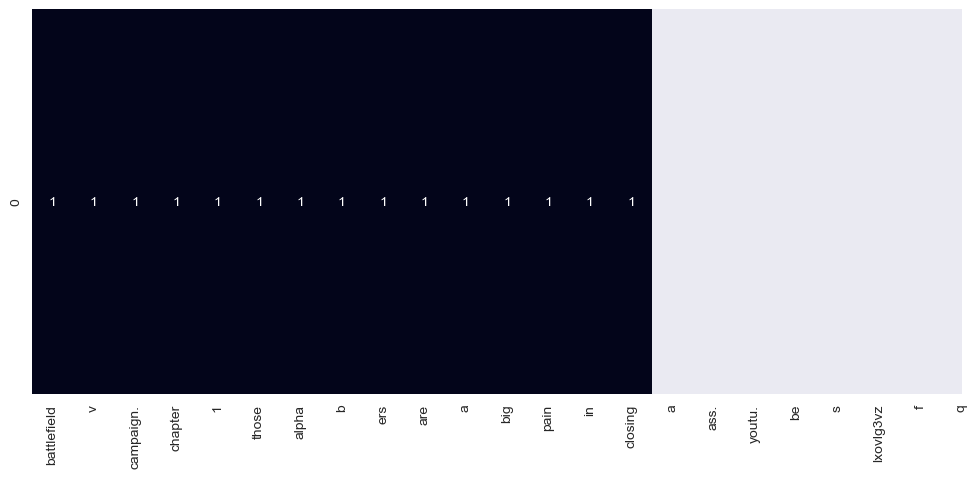

In [25]:
Counter=CountVectorizer()
transform=Counter.fit_transform([tested_text]).toarray()
plt.figure(figsize=(12,5))
sns.heatmap(transform, annot=True,xticklabels=tested_text.split(), 
        cbar=False)
transform

<center>
<div style="background-color: #FFC0CB; padding: 10px;">
<span style="color: blue;">

#### TF_IDF

</span>


</div>

It's like Victorization in addition to calculating the percentage for each word
![alt text](1_V9ac4hLVyms79jl65Ym_Bw.png)

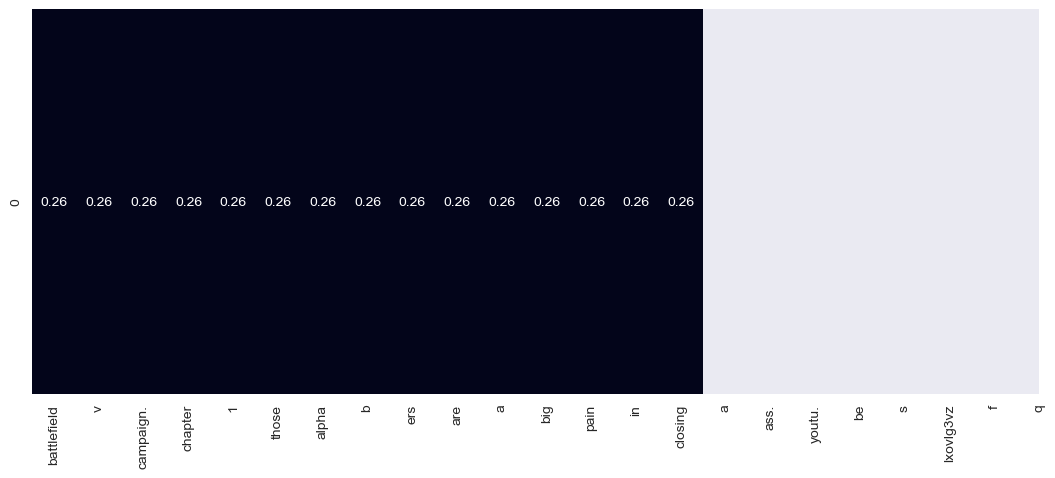

array([[0.25819889, 0.25819889, 0.25819889, 0.25819889, 0.25819889,
        0.25819889, 0.25819889, 0.25819889, 0.25819889, 0.25819889,
        0.25819889, 0.25819889, 0.25819889, 0.25819889, 0.25819889]])

In [26]:
TF_IDF = TfidfVectorizer()
transform=TF_IDF.fit_transform([tested_text]).toarray()
plt.figure(figsize=(13,5))
sns.heatmap(transform,annot=True,xticklabels=tested_text.split(), 
        cbar=False)
plt.show()
transform

<center>
<div style="background-color: #FFC0CB; padding: 10px;">
<span style="color: blue;">

#### N-grams

</span>


</div>

connect the followed words togather  
![alt text](8ARA1.png)

In [27]:
def get_top_m_ngram(corpus, n,m):
    vec = CountVectorizer(ngram_range=(n,n)).fit(corpus)#bag-of-words representation of the text corpus
    #ngram_range=(2, 2) specifies that we want to extract bigrams.
    bag_of_words = vec.transform(corpus)#transforms the corpus into a matrix of token counts.
    sum_words = bag_of_words.sum(axis=0)#calculates the total count of each word (bigram) across all documents.
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]# list contains tuples of bigrams and their corresponding counts.
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)# sorts the bigrams by count in descending order
    return words_freq[:m]

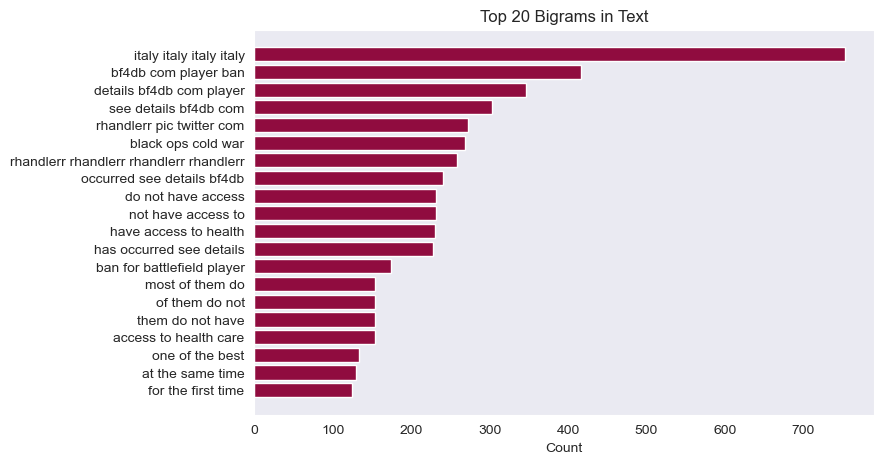

In [30]:
common_ngrams = get_top_m_ngram(train_df['sentence'], 4,20)

df_ngrams = pd.DataFrame(common_ngrams, columns=['bigram', 'count'])#transfer tuples into dataframe with bigram& counts columns 
hex_colors = ['#FF5733', '#33FF57', '#3357FF', '#FF33A1', '#FFC300', '#DAF7A6', '#C70039', '#581845', '#900C3F', '#FF5733']
plt.figure(figsize=(8,5))
plt.barh(df_ngrams['bigram'], df_ngrams['count'], color=random.choice(hex_colors))# plot a horizontal bar plot
plt.xlabel('Count')
plt.title('Top 20 Bigrams in Text')
plt.gca().invert_yaxis() # invert the Y axis 
plt.show()

<center>
<div style="background-color: #FFF0F5; padding: 10px;">

##### Positive
</div>

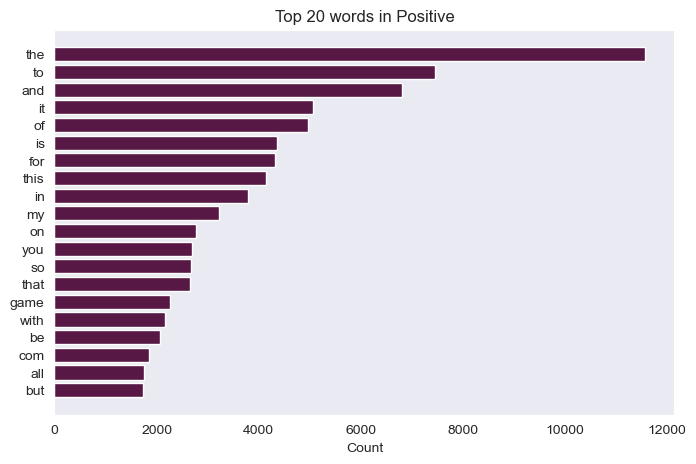

In [31]:
common_ngrams = get_top_m_ngram(train_df[train_df['feeling']=='Positive']['sentence'], 1,20)
df_ngrams = pd.DataFrame(common_ngrams, columns=['word', 'count'])#transfer tuples into dataframe with bigram& counts columns 

plt.figure(figsize=(8,5))
plt.barh(df_ngrams['word'], df_ngrams['count'], color=random.choice(hex_colors))# plot a horizontal bar plot
plt.xlabel('Count')
plt.title('Top 20 words in Positive')
plt.gca().invert_yaxis() # invert the Y axis 
plt.show()

<center>
<div style="background-color: #FFF0F5; padding: 10px;">

##### Negative
</div>

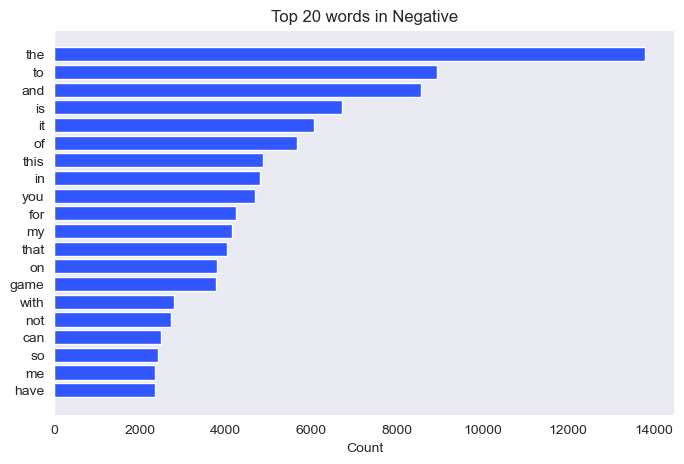

In [32]:
common_ngrams = get_top_m_ngram(train_df[train_df['feeling']=='Negative']['sentence'], 1,20)
df_ngrams = pd.DataFrame(common_ngrams, columns=['word', 'count'])#transfer tuples into dataframe with bigram& counts columns 

plt.figure(figsize=(8,5))
plt.barh(df_ngrams['word'], df_ngrams['count'], color=random.choice(hex_colors))# plot a horizontal bar plot
plt.xlabel('Count')
plt.title('Top 20 words in Negative')
plt.gca().invert_yaxis() # invert the Y axis 
plt.show()

<center>
<div style="background-color: #FFF0F5; padding: 10px;">

##### Neutral
</div>

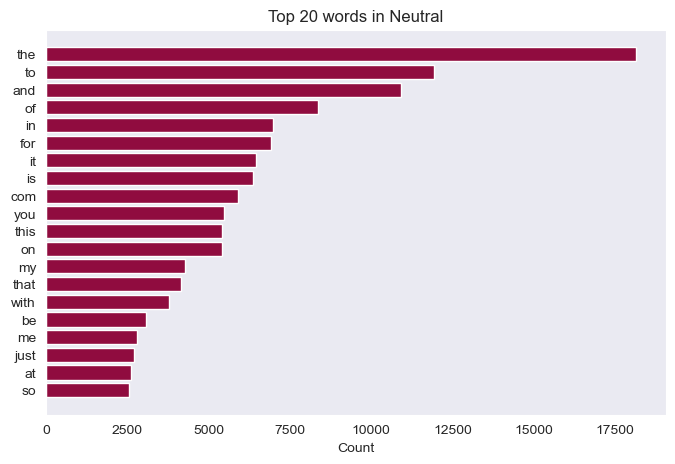

In [33]:
common_ngrams = get_top_m_ngram(train_df[train_df['feeling']=='Neutral']['sentence'], 1,20)
df_ngrams = pd.DataFrame(common_ngrams, columns=['word', 'count'])#transfer tuples into dataframe with bigram& counts columns 

plt.figure(figsize=(8,5 ))
plt.barh(df_ngrams['word'], df_ngrams['count'], color=random.choice(hex_colors))# plot a horizontal bar plot
plt.xlabel('Count')
plt.title('Top 20 words in Neutral')
plt.gca().invert_yaxis() # invert the Y axis 
plt.show()

<center>
<div style="background-color: #FFC0CB; padding: 10px;">
<span style="color: blue;">

#### StopWords

</span>


</div>

Stop words are words which are very common in a language. In many projects , they are deleted because they can not affect and they
can easily increase the volume of texts without any assistance

In [34]:
words=stopwords.words('english')

<center>
<div style="background-color: #FFC0CB; padding: 10px;">
<span style="color: blue;">

#### Stemmer

</span>


</div>
returning words to it's infinity 

![alt text](0_-yUy-dAKeTbPRQuk.png)


In [35]:
stemmer=PorterStemmer()
def stemming(text):

    stemmed_sentence=[stemmer.stem(token) for token in text]
    return stemmed_sentence
stemming(tokenized)

['battlefield',
 'v',
 'campaign',
 'chapter',
 '1',
 'those',
 'alpha',
 'b',
 'er',
 'are',
 'a',
 'big',
 'pain',
 'in',
 'close',
 'a',
 'ass',
 'youtu',
 'be',
 's',
 'lxovlg3vz',
 'f',
 'q']

<center>
<div style="background-color: #FFC0CB; padding: 10px;">
<span style="color: blue;">

#### Drop the extra long Sentences

</span>


</div>
when sentence has a huge lens, It's hard for our model to detrmine the classification from it 

In [36]:
lens=[len(tx) for tx in train_df['sentence'].to_list()]
condition=[x for x in lens if x >=200]
print(f'there are {len(condition)} sentences exceed 200 word which harmful to classify ')

there are 11051 sentences exceed 200 word which harmful to classify 


In [37]:
condition = train_df['sentence'].apply(lambda x: len(x) >= 200)
indexs=train_df[condition].index
train_df = train_df.drop(index=indexs)
train_df.reset_index(drop=True, inplace=True)

In [38]:
train_df.tail()

,source,feeling,sentence
59902,Nvidia,Positive,Just realized that the Windows partition of my...
59903,Nvidia,Positive,Just realized that my Mac window partition is ...
59904,Nvidia,Positive,Just realized the windows partition of my Mac ...
59905,Nvidia,Positive,Just realized between the windows partition of...
59906,Nvidia,Positive,Just like the windows partition of my Mac is l...


<center>


<center>
<div style="background-color: #DC143C; padding: 10px;">

### Applying the Previous Methods

</div>



In [39]:
train_df['sentence']=train_df['sentence'].apply(lambda x : clean_text(x))
train_df['sentence']=train_df['sentence'].apply(lambda x : tokenization(x))

train_df['sentence'].to_frame().head()

,sentence
0,"[i, am, getting, on, borderlands, and, i, will..."
1,"[i, am, coming, to, the, borders, and, i, will..."
2,"[i, am, getting, on, borderlands, and, i, will..."
3,"[i, am, coming, on, borderlands, and, i, will,..."
4,"[i, am, getting, on, borderlands, 2, and, i, w..."


In [40]:
stemmer = PorterStemmer()
stopwords_list = stopwords.words('english')

def setting_sentences(text):
    tokens = text.split()
    cleaned_tokens = [stemmer.stem(token) for token in tokens if token.lower() not in stopwords_list]
    sentence = ' '.join(cleaned_tokens)
    return sentence

In [41]:
train_df['sentence'] = train_df['sentence'].apply(lambda x: setting_sentences(' '.join(x)))


In [42]:
mapping = {'Positive':1,'Negative':0,'Neutral':2}
train_df['feeling'] = train_df['feeling'].map(mapping)

<center>
<div style="background-color: #FFC0CB; padding: 10px;">
<span style="color: blue;">

#### Split Data

</span>


</div>



In [43]:
x_train,x_test,y_train,y_test=train_test_split(train_df['sentence'],train_df['feeling'],test_size=.1,random_state=42)

In [44]:
y_train=np.array(y_train)
y_test=np.array(y_test)

<center>
<div style="background-color: #FFC0CB; padding: 10px;">
<span style="color: blue;">

#### Tokenization & pad Sequence

</span>


</div>


In [48]:
oov_token="<OOV>"
pad='post'
truncating='post'
max_len=35
vocab_size=23225

tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_token)
tokenizer.fit_on_texts(train_df['sentence'])
word_index=tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(x_train)
train_padded= pad_sequences(train_sequences,padding=pad,truncating=truncating,maxlen=max_len)
test_sequences = tokenizer.texts_to_sequences(x_test)
test_padded= pad_sequences(test_sequences,padding=pad,truncating=truncating,maxlen=max_len)

<center>
<div style="background-color: #DC143C; padding: 10px;">

###  Modeling
</div>


<center>
<div style="background-color: #FFC0CB; padding: 10px;">
<span style="color: blue;">

#### Model1 (embadding and Dense layers)

</span>


</div> 
In the world of applying NLP word embadding has proved to be one of the most powerful, useful to get good performance 

In [49]:
embadding_dim=16

model=Sequential()
model.add(Embedding(vocab_size, embadding_dim, input_length=max_len)) # it's a 2D array with shape         (maxlen,embadding_dim)
model.add(Flatten()) # we can use GlobalAveragePooling1D instead 
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(16,activation='relu'))

model.add(Dense(3,activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 16)            371600    
                                                                 
 flatten (Flatten)           (None, 560)               0         
                                                                 
 dense (Dense)               (None, 64)                35904     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 3)                 51        
                                                                 
Total params: 410163 (1.56 MB)
Trainable params: 410163

In [50]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


In [51]:
## This class is to just display the output per each 5 ephochs instead per each one

class DisplayEveryNEpochs(tf.keras.callbacks.Callback):
    def __init__(self, n=10):
        super(DisplayEveryNEpochs, self).__init__()
        self.n = n

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.n == 0:
            print(f"Epoch {epoch + 1}/{self.params['epochs']}:")
            print(f"Training loss: {logs['loss']:.4f}, Training accuracy: {logs['accuracy']:.4f}")
            print(f"Validation loss: {logs['val_loss']:.4f}, Validation accuracy: {logs['val_accuracy']:.4f}")

In [52]:

num_epochs=30
history=model.fit(train_padded,
          y_train,
          epochs=num_epochs,
          validation_data=(test_padded,y_test),
          verbose=0,
          callbacks=[DisplayEveryNEpochs(n=5)])

Epoch 5/30:
Training loss: 0.1020, Training accuracy: 0.9579
Validation loss: 0.4507, Validation accuracy: 0.8720
Epoch 10/30:
Training loss: 0.0708, Training accuracy: 0.9685
Validation loss: 0.5984, Validation accuracy: 0.8710
Epoch 15/30:
Training loss: 0.0604, Training accuracy: 0.9723
Validation loss: 0.7905, Validation accuracy: 0.8680
Epoch 20/30:
Training loss: 0.0534, Training accuracy: 0.9748
Validation loss: 1.0160, Validation accuracy: 0.8648
Epoch 25/30:
Training loss: 0.0515, Training accuracy: 0.9757
Validation loss: 1.0232, Validation accuracy: 0.8618
Epoch 30/30:
Training loss: 0.0470, Training accuracy: 0.9774
Validation loss: 1.2600, Validation accuracy: 0.8595


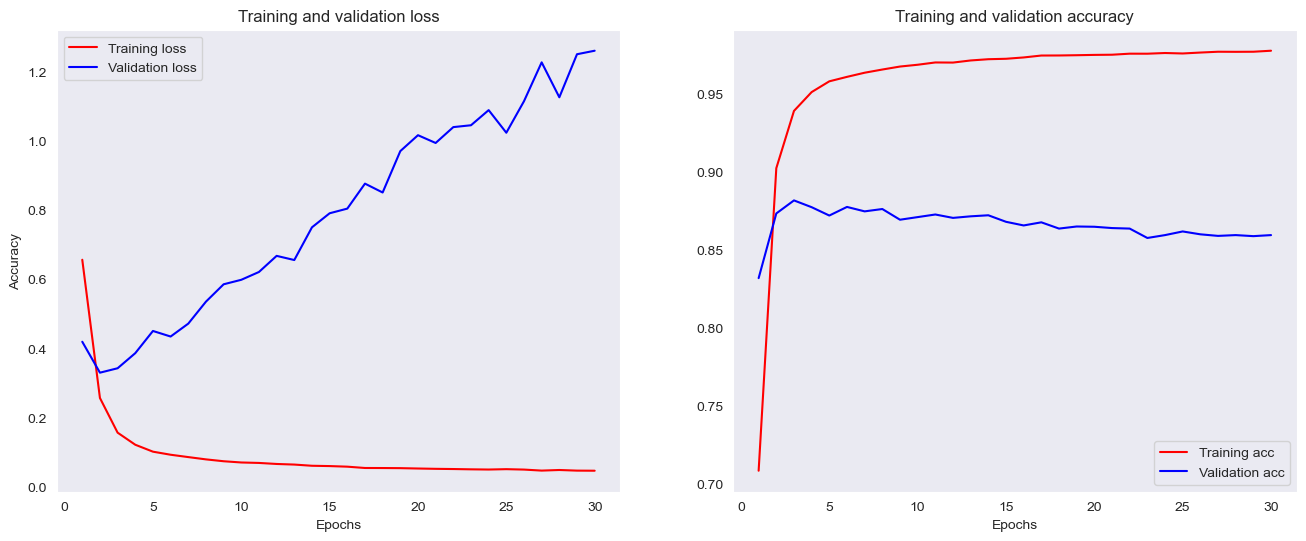

In [53]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)
fig, axs= plt.subplots(1,2 ,figsize=(16,6))
axs[0].plot(epochs, train_loss, 'r', label='Training loss')
axs[0].plot(epochs, val_loss, 'b', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(epochs, train_acc, 'r', label='Training acc')
axs[1].plot(epochs, val_acc, 'b', label='Validation acc')
axs[1].set_title('Training and validation accuracy')
axs[1].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[1].legend()
plt.show()


Based on the graph provided, the model demonstrates good performance in terms of accuracy; however, the validation loss increases with each epoch (ranging from 0.4 to 1.2), suggesting that the model is overfitting.

Runtime:
The model took approximately a minute and a half to complete 30 epochs, which is a relatively efficient runtime.


<center>
<div style="background-color: #FFC0CB; padding: 10px;">
<span style="color: blue;">

#### Model2 ==> CNN
</span>



In [54]:
model2 = Sequential()

model2.add(Embedding(vocab_size, embadding_dim, input_length=max_len))

model2.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

model2.add(MaxPooling1D(pool_size=2))

model2.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
model2.add(Flatten())

model2.add(Dense(3, activation='softmax'))
model2.summary()

model2.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 35, 16)            371600    
                                                                 
 conv1d (Conv1D)             (None, 33, 32)            1568      
                                                                 
 max_pooling1d (MaxPooling1  (None, 16, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 14, 16)            1552      
                                                                 
 flatten_1 (Flatten)         (None, 224)               0         
                                                                 
 dense_4 (Dense)             (None, 3)                 675       
                                                     

In [55]:
num_epochs=30
history2=model2.fit(train_padded,
          y_train,
          epochs=num_epochs,
          validation_data=(test_padded,y_test),
          verbose=0,
          callbacks=[DisplayEveryNEpochs(n=5)])

Epoch 5/30:
Training loss: 0.1207, Training accuracy: 0.9503
Validation loss: 0.3796, Validation accuracy: 0.8805
Epoch 10/30:
Training loss: 0.0701, Training accuracy: 0.9697
Validation loss: 0.5622, Validation accuracy: 0.8817
Epoch 15/30:
Training loss: 0.0577, Training accuracy: 0.9740
Validation loss: 0.8300, Validation accuracy: 0.8787
Epoch 20/30:
Training loss: 0.0523, Training accuracy: 0.9757
Validation loss: 0.9687, Validation accuracy: 0.8721
Epoch 25/30:
Training loss: 0.0496, Training accuracy: 0.9765
Validation loss: 1.1093, Validation accuracy: 0.8725
Epoch 30/30:
Training loss: 0.0471, Training accuracy: 0.9778
Validation loss: 1.2156, Validation accuracy: 0.8730


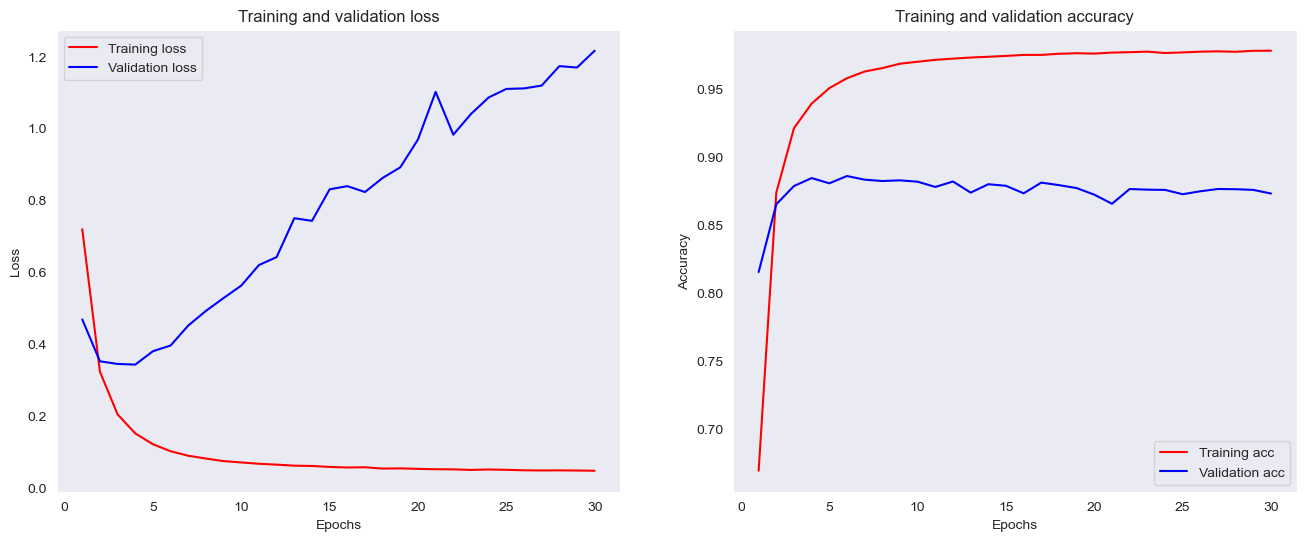

In [56]:
train_loss=history2.history['loss']
val_loss=history2.history['val_loss']
train_acc=history2.history['accuracy']
val_acc=history2.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)
fig, axs= plt.subplots(1,2,figsize=(16,6))

axs[0].plot(epochs, train_loss, 'r', label='Training loss')
axs[0].plot(epochs, val_loss, 'b', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(epochs, train_acc, 'r', label='Training acc')
axs[1].plot(epochs, val_acc, 'b', label='Validation acc')
axs[1].set_title('Training and validation accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.show()


As like the first model, the model2 demonstrates good performance in terms of accuracy; however, the validation loss increases with each epoch (ranging from 0.4 to 1.1), suggesting that the model is overfitting.

Runtime:
The model took approximately 2 minutes to complete 30 epochs, which is a relatively efficient runtime.

<center>
<div style="background-color: #FFC0CB; padding: 10px;">
<span style="color: blue;">

#### Model3 ==> Bidirectional LSTM
</span>


</div> 


In [57]:
model3=Sequential()
model3.add(Embedding(vocab_size, embadding_dim, input_length=max_len)) # it's a 2D array with shape         (maxlen,embadding_dim)
model3.add(Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True))) # 64 is the desired output from that layer and it will give 128 as it Bidirectional
model3.add(Bidirectional(tf.keras.layers.LSTM(16)))
model3.add(Dense(16,activation='softmax'))


model3.add(Dense(3,activation='softmax'))
model3.summary()

model3.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 35, 16)            371600    
                                                                 
 bidirectional (Bidirection  (None, 35, 64)            12544     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dense_6 (Dense)             (None, 3)                 51        
                                                                 
Total params: 395091 (1.51 MB)
Trainable params: 39509

In [58]:
num_epochs=30
history3=model3.fit(train_padded,
          y_train,
          epochs=num_epochs,
          validation_data=(test_padded,y_test),
          verbose=0,
          callbacks=[DisplayEveryNEpochs(n=5)])

Epoch 5/30:
Training loss: 0.2581, Training accuracy: 0.9086
Validation loss: 0.3830, Validation accuracy: 0.8570
Epoch 10/30:
Training loss: 0.1470, Training accuracy: 0.9433
Validation loss: 0.3627, Validation accuracy: 0.8843
Epoch 15/30:
Training loss: 0.1042, Training accuracy: 0.9576
Validation loss: 0.3910, Validation accuracy: 0.8903
Epoch 20/30:
Training loss: 0.0823, Training accuracy: 0.9652
Validation loss: 0.4288, Validation accuracy: 0.8932
Epoch 25/30:
Training loss: 0.0709, Training accuracy: 0.9692
Validation loss: 0.4671, Validation accuracy: 0.8938
Epoch 30/30:
Training loss: 0.0634, Training accuracy: 0.9725
Validation loss: 0.5142, Validation accuracy: 0.8933


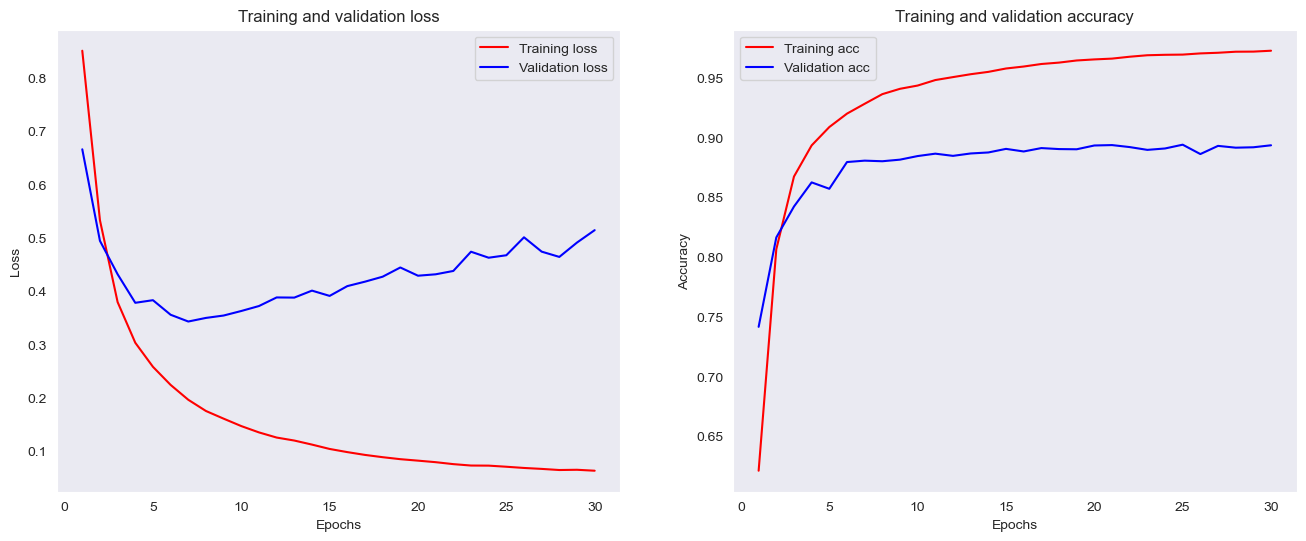

In [59]:
train_loss=history3.history['loss']
val_loss=history3.history['val_loss']
train_acc=history3.history['accuracy']
val_acc=history3.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)
fig, axs= plt.subplots(1,2,figsize=(16,6))

axs[0].plot(epochs, train_loss, 'r', label='Training loss')
axs[0].plot(epochs, val_loss, 'b', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(epochs, train_acc, 'r', label='Training acc')
axs[1].plot(epochs, val_acc, 'b', label='Validation acc')
axs[1].set_title('Training and validation accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.show()


In contrast, Model3 performs well in terms of validation loss. However, it requires a substantial runtime of approximately 12 minutes, which is considerably longer.

Overall, CNN & Dense ==> short Runtime - overfitting
Overall, LSTM ==> long Runtime -good validation loss

In [60]:
e=model.layers[0]
weights=e.get_weights()[0]

reverse_word_index=tokenizer.index_word
out_v= io.open('vecs.tsv','w',encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1,vocab_size):
    word=reverse_word_index[word_num]
    embeddings=weights[word_num]
    out_m.write(word+'\n')
    out_v.write('\t'.join([str(x) for x in embeddings])+'\n')
out_v.close()
out_m.close()



KeyError: 19459

![alt text](<Screenshot (101).png>)

<center>
<div style="background-color: #8B0000; padding: 10px;">

# Thank YOU         Thank YOU
</div>